
**Step 1: Importing required Libraries**

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from google.colab import drive
import os
import time
from tqdm.notebook import tqdm
print("Libraries imported successfully.")

Libraries imported successfully.


**Step 2: Using Google Drive for xy_data for easier importation of data and storing results**

In [2]:
DRIVE_MOUNT_PATH = '/content/drive'
drive.mount(DRIVE_MOUNT_PATH, force_remount=True)

print("\nGoogle Drive mounted successfully.")

Mounted at /content/drive

Google Drive mounted successfully.


**Step 3: Loading and Processing the data from drive**

In [6]:
FILE_NAME = 'xy_data.csv'
FILE_PATH = os.path.join(DRIVE_MOUNT_PATH, 'My Drive', FILE_NAME)
if os.path.exists(FILE_PATH):
    print(f"Loading data from: {FILE_PATH}")
    df = pd.read_csv(FILE_PATH)
    t_vec = np.linspace(6, 60, 1500)
    df['sort_key'] = df['x'] + df['y']
    df_sorted = df.sort_values(by='sort_key').reset_index(drop=True)
    x_true = df_sorted['x'].values
    y_true = df_sorted['y'].values
    print(f"\nData loaded and sorted. {len(x_true)} points ready for analysis.")
    print("t vector shape:", t_vec.shape)
    print("x_true shape:", x_true.shape)
    print("y_true shape:", y_true.shape)
else:
    print(f"Error: File not found at '{FILE_PATH}'.")
    print("Please make sure 'xy_data.csv' is in your Google Drive and the FILE_PATH is correct.")
    df = None

Loading data from: /content/drive/My Drive/xy_data.csv

Data loaded and sorted. 1500 points ready for analysis.
t vector shape: (1500,)
x_true shape: (1500,)
y_true shape: (1500,)


**Cell 4: Visualzing Raw Data vs Sorted (x+y) Heuristic Data**

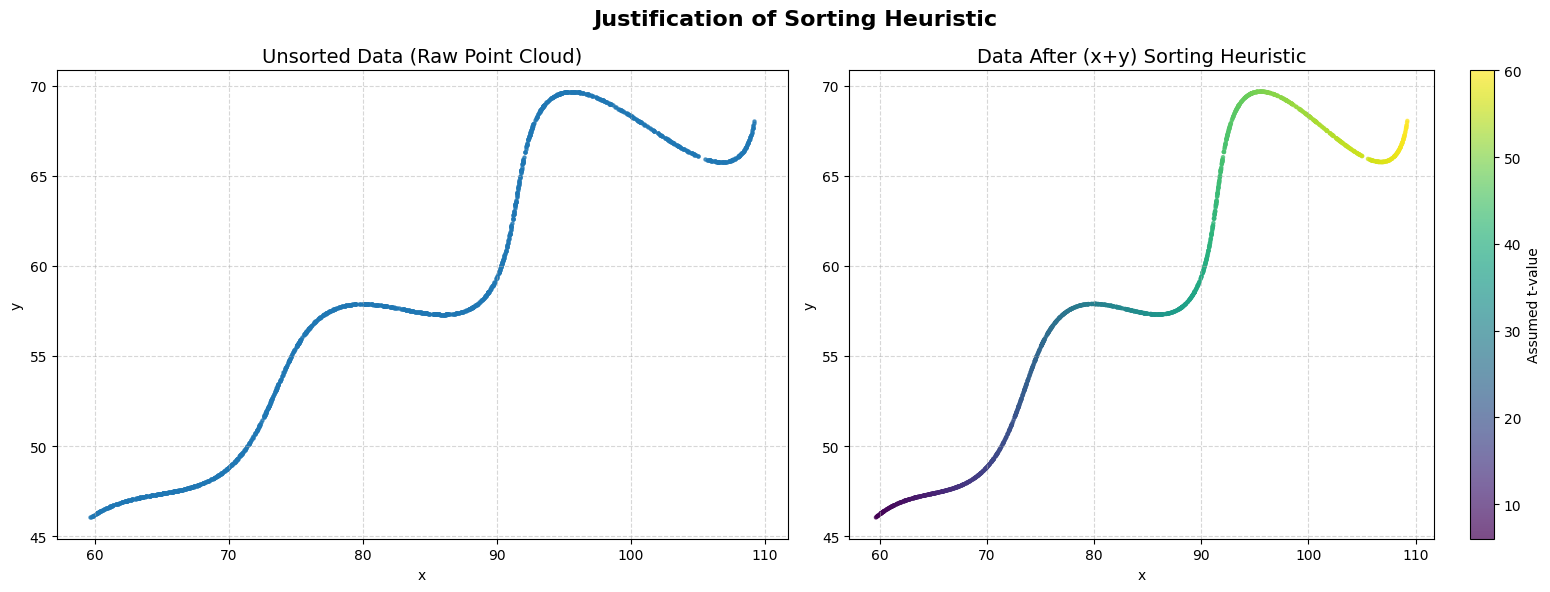

In [7]:
if df is not None:
    plt.figure(figsize=(16, 6))

    # Plot 1:Raw data
    plt.subplot(1, 2, 1)
    plt.scatter(df['x'], df['y'], s=5, alpha=0.7)
    plt.title('Unsorted Data (Raw Point Cloud)', fontsize=14)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Plot 2: x+y sorted data
    plt.subplot(1, 2, 2)
    plt.scatter(x_true, y_true, s=5, c=t_vec, cmap='viridis', alpha=0.7)
    plt.title('Data After (x+y) Sorting Heuristic', fontsize=14)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(label='Assumed t-value')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.suptitle('Justification of Sorting Heuristic', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Data not loaded. Please run Cell 3 first.")

**Step 5: Defining Parametric Model and L1 Loss Functions**

In [8]:
def parametric_model(params, t):
    theta, M, X = params
    x_pred = (t * np.cos(theta) - np.exp(M * t) * np.sin(0.3 * t) * np.sin(theta) + X)
    y_pred = (42 + t * np.sin(theta) + np.exp(M * t) * np.sin(0.3 * t) * np.cos(theta))
    return x_pred, y_pred
def objective_function(params, t_vec, x_true, y_true):
    x_pred, y_pred = parametric_model(params, t_vec)
    loss_x = np.mean(np.abs(x_pred - x_true))
    loss_y = np.mean(np.abs(y_pred - y_true))

    return loss_x + loss_y

print("Model and Objective Function defined.")

Model and Objective Function defined.


**Step 6: Running Global Optimization**

In [11]:
if 't_vec' in locals():
    theta_bounds = (0, np.deg2rad(50))
    M_bounds = (-0.05, 0.05)
    X_bounds = (0, 100)
    bounds = [theta_bounds, M_bounds, X_bounds]
    MAX_ITERATIONS = 2000
    pbar = tqdm(total=MAX_ITERATIONS, desc="Optimizing Parameters")
    def optimization_callback(xk, convergence):
        pbar.update(1)
    print(f"Starting Differential Evolution for {MAX_ITERATIONS} iterations...")
    start_time = time.time()
    result = differential_evolution(
        objective_function,
        bounds,
        args=(t_vec, x_true, y_true),
        strategy='best1bin',
        maxiter=MAX_ITERATIONS,
        popsize=50,
        tol=1e-5,
        mutation=(0.5, 1),
        recombination=0.7,
        disp=False,
        workers=-1,
        callback=optimization_callback,
        polish=True
    )
    pbar.close()
    end_time = time.time()
    print(f"\nOptimization finished in {end_time - start_time:.2f} seconds.")
    if result.success:
        print(f"Optimizer converged successfully.")
        optimal_params = result.x
        final_loss = result.fun
        print(f"\n--- Final Optimized Results ---")
        print(f"Optimal Parameters (theta, M, X): {optimal_params}")
        print(f"Final L1 Loss (MAE): {final_loss}")
    else:
        print("Optimization did not converge.")
        optimal_params = None

Optimizing Parameters:   0%|          | 0/2000 [00:00<?, ?it/s]

Starting Differential Evolution for 2000 iterations...

Optimization finished in 3.67 seconds.
Optimizer converged successfully.

--- Final Optimized Results ---
Optimal Parameters (theta, M, X): [5.24362598e-01 2.99893988e-02 5.50155781e+01]
Final L1 Loss (MAE): 0.3022913466579007


**Step 7: Data Visualization: Checking our graph we got VS compairing it with the original result**

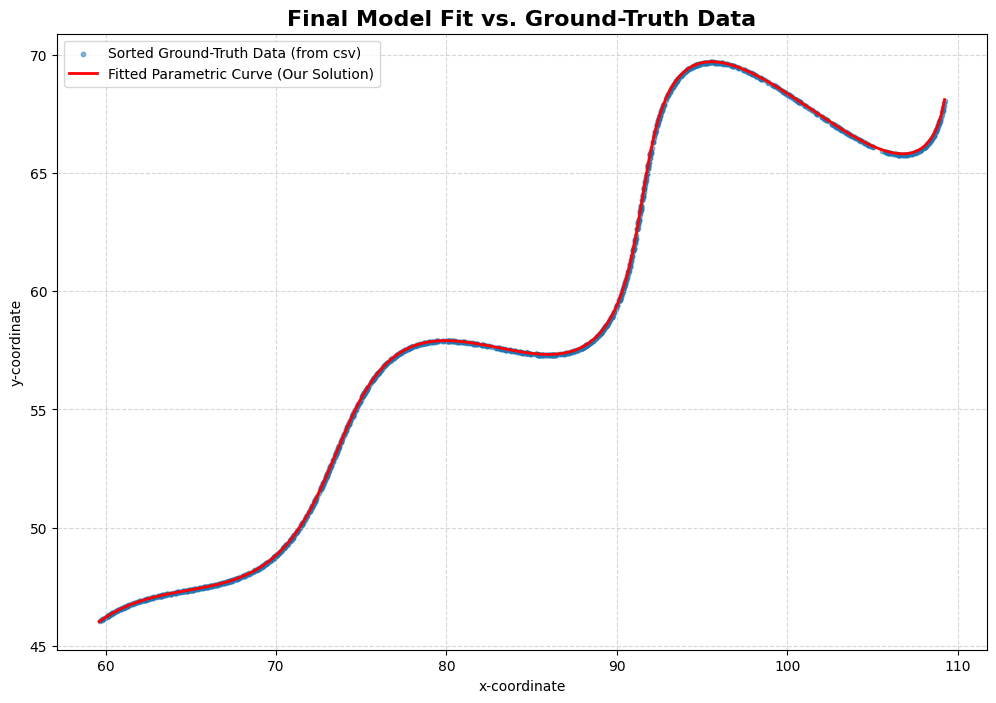

In [12]:
if optimal_params is not None:
    x_pred, y_pred = parametric_model(optimal_params, t_vec)
    plt.figure(figsize=(12, 8))
    plt.scatter(x_true, y_true, label='Sorted Ground-Truth Data (from csv)', s=10, alpha=0.5)
    plt.plot(x_pred, y_pred, color='red', linewidth=2, label='Fitted Parametric Curve (Our Solution)')
    plt.title('Final Model Fit vs. Ground-Truth Data', fontsize=16, fontweight='bold')
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
else:
    print("Optimization was not successful or not run. Skipping plot.")



**Step 8: Saving Results in Google Drive**



In [15]:
if optimal_params is not None:
    print("Saving results to Google Drive...")
    RESULTS_FOLDER_PATH = os.path.join(DRIVE_MOUNT_PATH, 'My Drive', 'Parametric_Curve_Results')
    os.makedirs(RESULTS_FOLDER_PATH, exist_ok=True)
    PLOT_FILE_PATH = os.path.join(RESULTS_FOLDER_PATH, 'final_model_fit.png')
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(x_true, y_true, label='Sorted Ground-Truth Data (from csv)', s=10, alpha=0.5)
    ax.plot(x_pred, y_pred, color='red', linewidth=2, label='Fitted Parametric Curve (Our Solution)')
    ax.set_title('Final Model Fit vs. Ground-Truth Data', fontsize=16, fontweight='bold')
    ax.set_xlabel('x-coordinate')
    ax.set_ylabel('y-coordinate')
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(PLOT_FILE_PATH)
    plt.close(fig)
    print(f"Saved plot to: {PLOT_FILE_PATH}")
    theta_opt, M_opt, X_opt = optimal_params
    e_part = f"e^{{\\left{{{M_opt}}}|t|\\right}}}}"
    submission_string = (
        f"\\left( (t*\\cos({theta_opt}) - {e_part} \\cdot "
        f"\\sin(0.3t)\\sin({theta_opt}) + {X_opt}, 42 + t*\\sin({theta_opt}) + "
        f"{e_part} \\cdot \\sin(0.3t)\\cos({theta_opt}) \\right) \\right)"
    )
    TEXT_FILE_PATH = os.path.join(RESULTS_FOLDER_PATH, 'results.txt')
    with open(TEXT_FILE_PATH, 'w') as f:
        f.write(f"--- Parametric Curve Optimization Results ---\n")
        f.write(f"Report generated on: {time.asctime()}\n\n")
        f.write(f"Optimal Parameters (from Optimizer):\n")
        f.write(f"  theta = {theta_opt}\n")
        f.write(f"  M = {M_opt}\n")
        f.write(f"  X = {X_opt}\n\n")
        f.write(f"Final L1 Loss (MAE): {final_loss}\n\n")
        f.write(f"--- Final Submission String ---\n")
        f.write(submission_string)

    print(f"Saved results file to: {TEXT_FILE_PATH}")
    print("\nAll results have been successfully saved to your Google Drive.")

else:
    print("Optimization was not successful or not run. No results to save.")

Saving results to Google Drive...
Saved plot to: /content/drive/My Drive/Parametric_Curve_Results/final_model_fit.png
Saved results file to: /content/drive/My Drive/Parametric_Curve_Results/results.txt

All results have been successfully saved to your Google Drive.
